In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel   = False
parallel_nprc = 48   # number of dask workers
parallel_tmem = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None # '~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None 
do_allcycl= True 
vname     = 'temp'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/' # None
ref_name  = None # 'TKE' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
box_regions = list()
box_regions.append('ocean_basins/Arctic_Basin.shp')
box_regions.append('ocean_basins/Eurasian_Basin.shp')
box_regions.append('mpas_region/Canada_Basin.shp')
box_regions.append('mpas_region/North_Atlantic_Ocean.shp')
box_regions.append('mpas_region/Greenland_Sea.shp')
box_regions.append('mpas_region/Irminger_Sea.shp')
box_regions.append('mpas_region/Norwegian_Sea.shp')
box_regions.append('mpas_region/Labrador_Sea.shp')
box_regions.append('mpas_region/North_Pacific_Ocean.shp')
box_regions.append('mpas_region/South_Pacific_Ocean.shp')
box_regions.append('mpas_region/Southern_Ocean.shp')
box_regions.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
do_clim   = True
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
ncol, nrow        = 4 , None
plt_opt           = dict({'marker':'o'})
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
save_dpi          = 300
save_fmt          = ['png']

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if n_cycl is not None:
    cycl_s = n_cycl
    if do_allcycl: cycl_s=1
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name

    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    

#______________________________________________________________________________________________________
# in case of diff plots
if (ref_path is not None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
        
#________________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_regions:
    if region == 'global' or isinstance(region,list): 
        print('global')
        box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))   

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
/albedo/home/pscholz/tripyview/tripyview ocean_basins/Arctic_Basin.shp
/albedo/home/pscholz/tripyview/tripyview ocean_basins/Eurasian_Basin.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/Canada_Basin.shp
/albedo/home/pscholz/tripyview/tripyview mpas_region/North_Atlantic_Ocean.shp
/albedo/home/pscholz/

In [5]:
data_list = list()
#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (ref_path is None):
    if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and do_clim : 
        clim_vname = vname
        ts = clock.time()
        if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
        elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
        clim = tpv.load_climatology(mesh, clim_path, clim_vname, do_load=False, do_persist=True)
        print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
        print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))

        ts = clock.time()
        data_list.append(tpv.load_index_fesom2(mesh, clim, box, do_harithm='wmean'))
        print(' --> elasped time to comp. vert. clim profile.: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 
    else: raise ValueError('climatology not supported for choosen vname')  

#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    #__________________________________________________________________________________________________
    data       = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, descript=descript , 
                                      do_info=False, do_zarithm=None, do_load=False, do_persist=True)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))

    #__________________________________________________________________________________________________    
    # create reference vert. profile if given 
    if (ii==0) and (ref_path != None):
        ts = clock.time()
        data_ref = tpv.load_index_fesom2(mesh, data, box) 
        print(' --> elasped time to comp. vert. ref profile.: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 
    
        # --> zero reference line
        data_list.append(tpv.do_indexanomaly(data_ref, data_ref))
        continue
        
    #__________________________________________________________________________________________________  
    # create vert. profile --> collect the lines in a list
    ts = clock.time()
    data_index = tpv.load_index_fesom2(mesh, data, box)
    print(' --> elasped time to comp. vert. profile.: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 
    if  (ref_path != None and ref_path != 'None'): 
        data_list.append(tpv.do_indexanomaly(data_index, data_ref))
    else:
        data_list.append(data_index)
    
if  (ref_path != None): del(data_ref)

 --> elasped time to load clim: 0.01 min.
 --> clim uses 0.05 Gb:


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


 --> elasped time to comp. vert. clim profile.: 0.01 min.
0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load data: 0.15 min.
 --> data uses 0.05 Gb:
 --> elasped time to comp. vert. profile.: 0.01 min.
1 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elasped time to load data: 0.15 min.
 --> data uses 0.05 Gb:
 --> elasped time to comp. vert. profile.: 0.01 min.
2 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elasped time to load data: 0.16 min.
 --> data uses 0.05 Gb:
 --> elasped time to comp. vert. profile.: 0.01 min.
3 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.17 min.
 --> data uses 0.05 Gb:
 --> elasped time to comp. vert. profile.: 0.01 min.


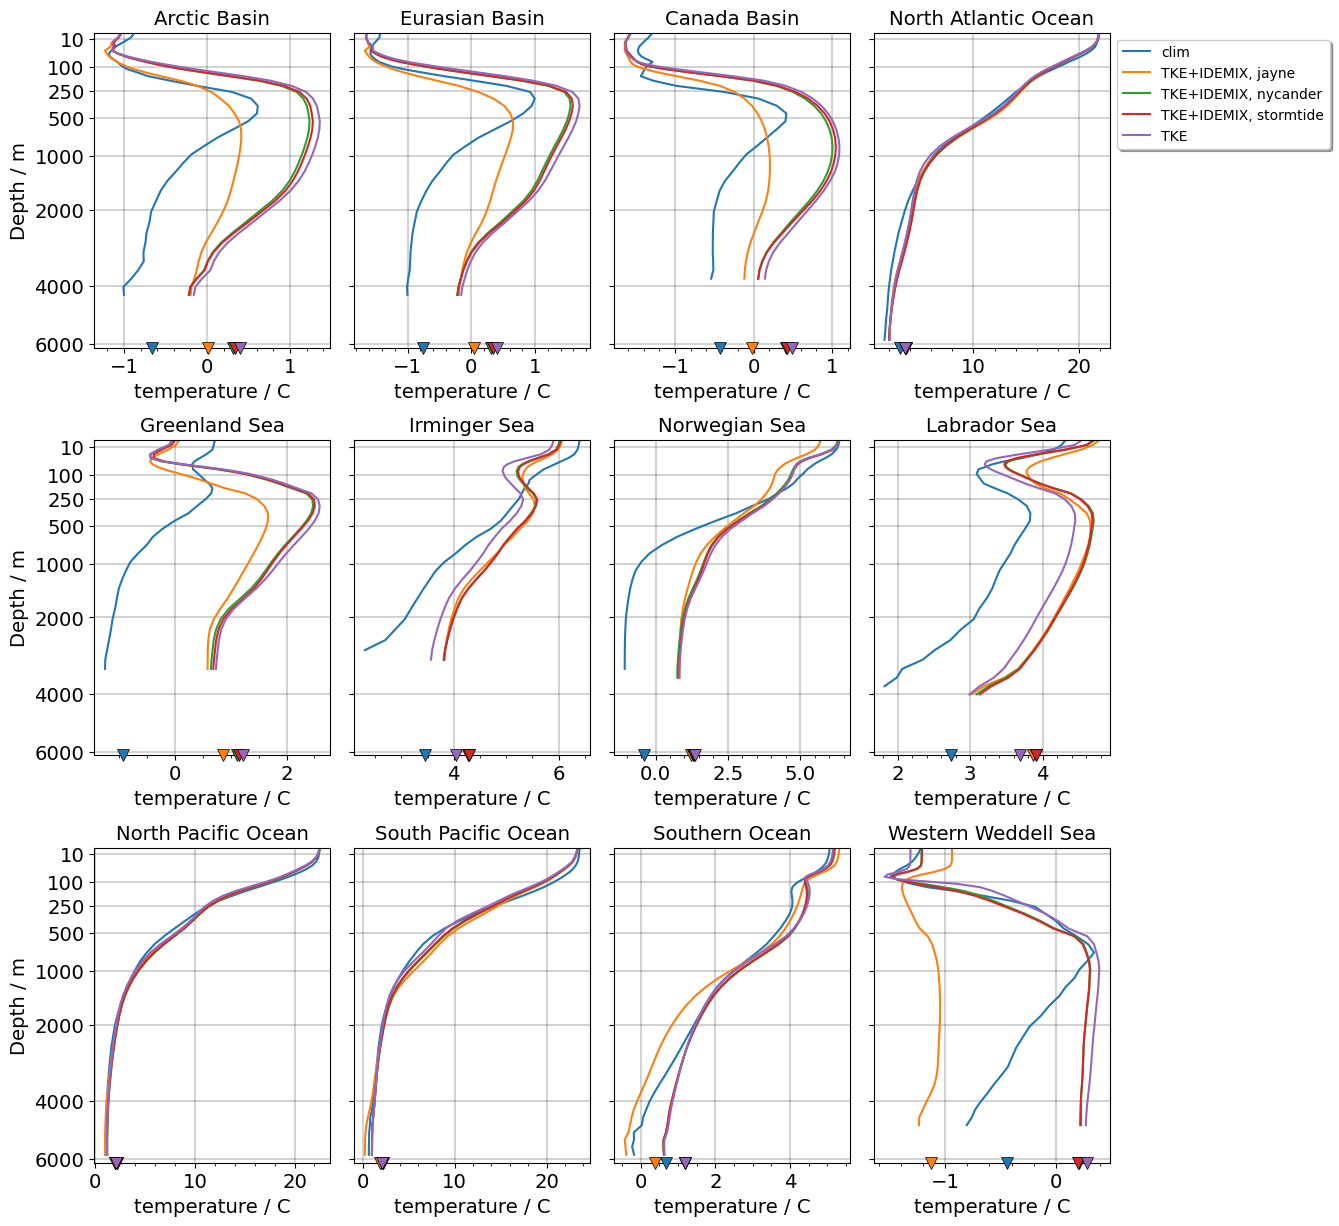

In [6]:
ncol0  = np.min([ncol,len(box)])    
nrow0  = np.ceil(len(box)/ncol0).astype('int')
if nrow != None: nrow0=nrow  
idx0=1 if do_clim else 0    
svname = list(data_list[idx0][0].data_vars)[0]
slabel = data_list[idx0][0][svname].attrs['str_lsave']
# sbox   = data_list[0][0][svname].attrs['boxname'].replace(' ','_').lower()

#__________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'vline', stname ,slabel, sfmt)) )
#__________________________________________________________________________________________________
hfig, hax = tpv.plot_vline(data_list           , 
                    box        = box           , 
                    box_idx    = None          ,
                    boxl_opt   = dict()        , # option for box label string 
                    nrow       = nrow0         , # number of row in figures panel
                    ncol       = ncol0         ,
                    ax_opt=dict({'fig_sizefac':2,}),
                    do_allcycl = do_allcycl    ,   
                    n_cycl     = n_cycl        ,
                    do_enum    = do_enum       ,
                    do_shdw    = do_shdw       ,
                    do_mean    = do_mean       ,
                    do_save    = sfpath, save_dpi=save_dpi,) 